# Experiment 3: Fire January set (PWWB + AirNow)

This notebook focuses on running Experiment 3, which uses data from January (fire period) combining PWWB and AirNow datasets.

# Data parameters

In [ ]:
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.00
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data - January only for this experiment
jan_start_date, jan_end_date = "2025-01-16-00", "2025-01-23-00"

# Data ingestion and preprocessing

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv

# Import the data classes
from libs.pwwbdata import PWWBData
from libs.airnowdata import AirNowData

# Load environment variables (API keys, credentials)
load_dotenv()

# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [3]:
# Create output directory for results
output_dir = "experiment_output"
os.makedirs(output_dir, exist_ok=True)
jan_end_date_adj = pd.to_datetime(jan_end_date) - pd.Timedelta(hours=1)

# ========== 1. Load January PWWB Data ==========
print("\nLoading January PWWB data...")
jan_pwwb = PWWBData(
    start_date=jan_start_date,
    end_date=jan_end_date,
    extent=extent,
    frames_per_sample=frames_per_sample,
    dim=dim,
    env_file='.env',
    verbose=True,
    output_dir=output_dir
)
X_jan_pwwb = jan_pwwb.data
channel_info = jan_pwwb.get_channel_info()
print(f"✓ January PWWB data shape: {X_jan_pwwb.shape}")
print(f"  Channels: {channel_info['channel_order']}")

# ========== 2. Load January AirNow Data ==========
print("\nLoading January AirNow data...")
jan_airnow = AirNowData(
    start_date=jan_start_date,
    end_date=jan_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_jan_airnow = jan_airnow.data
Y_jan = jan_airnow.target_stations
print(f"✓ January AirNow data shape: {X_jan_airnow.shape}")
if Y_jan is not None:
    print(f"  January target stations shape: {Y_jan.shape}")
else:
    print("  No January target stations available")


Loading January PWWB data...
Initialized PWWBData with 168 hourly timestamps
Date range: 2025-01-16 00:00:00 to 2025-01-22 23:00:00
Initialized PWWBData with 168 hourly timestamps
Date range: 2025-01-16 00:00:00 to 2025-01-22 23:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Loading cached TROPOMI data from data/pwwb_cache/tropomi_data.npy
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Loading cached MERRA-2 data from data/pwwb_cache/merra2_data.npy
Processing meteorological data...
Loading cached METAR data from data/pwwb_cache/metar_data.npy
Final data shape: (164, 5, 200, 200, 16)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: -28672.000000000004
  Max: -7077.939142950936
  Mean: -17808.547363862024
  Std: 5660.42236053651
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 1: TROPOMI_Methane
  Min: 1896.2036742630473
  Max: 1925.3769

In [4]:
# ========== 3. Create Experiment 3 dataset ==========
print("\nCreating Experiment 3 dataset...")

# Experiment 3: Fire January set (PWWB + AirNow)
print("  Experiment 3: Fire January set (PWWB + AirNow)")
X_exp3 = np.concatenate([X_jan_pwwb, X_jan_airnow], axis=-1)
print(f"    Combined shape: {X_exp3.shape}")


Creating Experiment 3 dataset...
  Experiment 3: Fire January set (PWWB + AirNow)
    Combined shape: (164, 5, 200, 200, 17)


In [5]:
# ========== 4. Train/Test Split for experiment ==========
print("\nCreating train/test splits for experiment...")
# Experiment 3 splits
X_exp3_train, X_exp3_test = train_test_split(X_exp3, train_size=0.75)
Y_jan_train, Y_jan_test = train_test_split(Y_jan, train_size=0.75)
print(f"  Experiment 3: Train={X_exp3_train.shape}, Test={X_exp3_test.shape}")

# ========== 5. Standardize data ==========
print("\nStandardizing data...")

# Experiment 3 standardization
X_exp3_train_scaled, X_exp3_test_scaled = std_scale(X_exp3_train, X_exp3_test)
print(f"  Experiment 3: Scaled train={X_exp3_train_scaled.shape}, test={X_exp3_test_scaled.shape}")


Creating train/test splits for experiment...
  Experiment 3: Train=(123, 5, 200, 200, 17), Test=(41, 5, 200, 200, 17)

Standardizing data...
  Experiment 3: Scaled train=(123, 5, 200, 200, 17), test=(41, 5, 200, 200, 17)


In [6]:
# ========== 6. Save prepared datasets ==========
print("\nSaving prepared dataset...")

# Create directory for experiment
exp_dir = os.path.join(output_dir, "experiment3")
os.makedirs(exp_dir, exist_ok=True)

# Save Experiment 3 data
np.save(os.path.join(exp_dir, "X_train.npy"), X_exp3_train_scaled)
np.save(os.path.join(exp_dir, "X_test.npy"), X_exp3_test_scaled)
np.save(os.path.join(exp_dir, "y_train.npy"), Y_jan_train)
np.save(os.path.join(exp_dir, "y_test.npy"), Y_jan_test)

print("\n✓ Dataset prepared and saved!")


Saving prepared dataset...

✓ Dataset prepared and saved!


# Data visualization

Visualizing data...


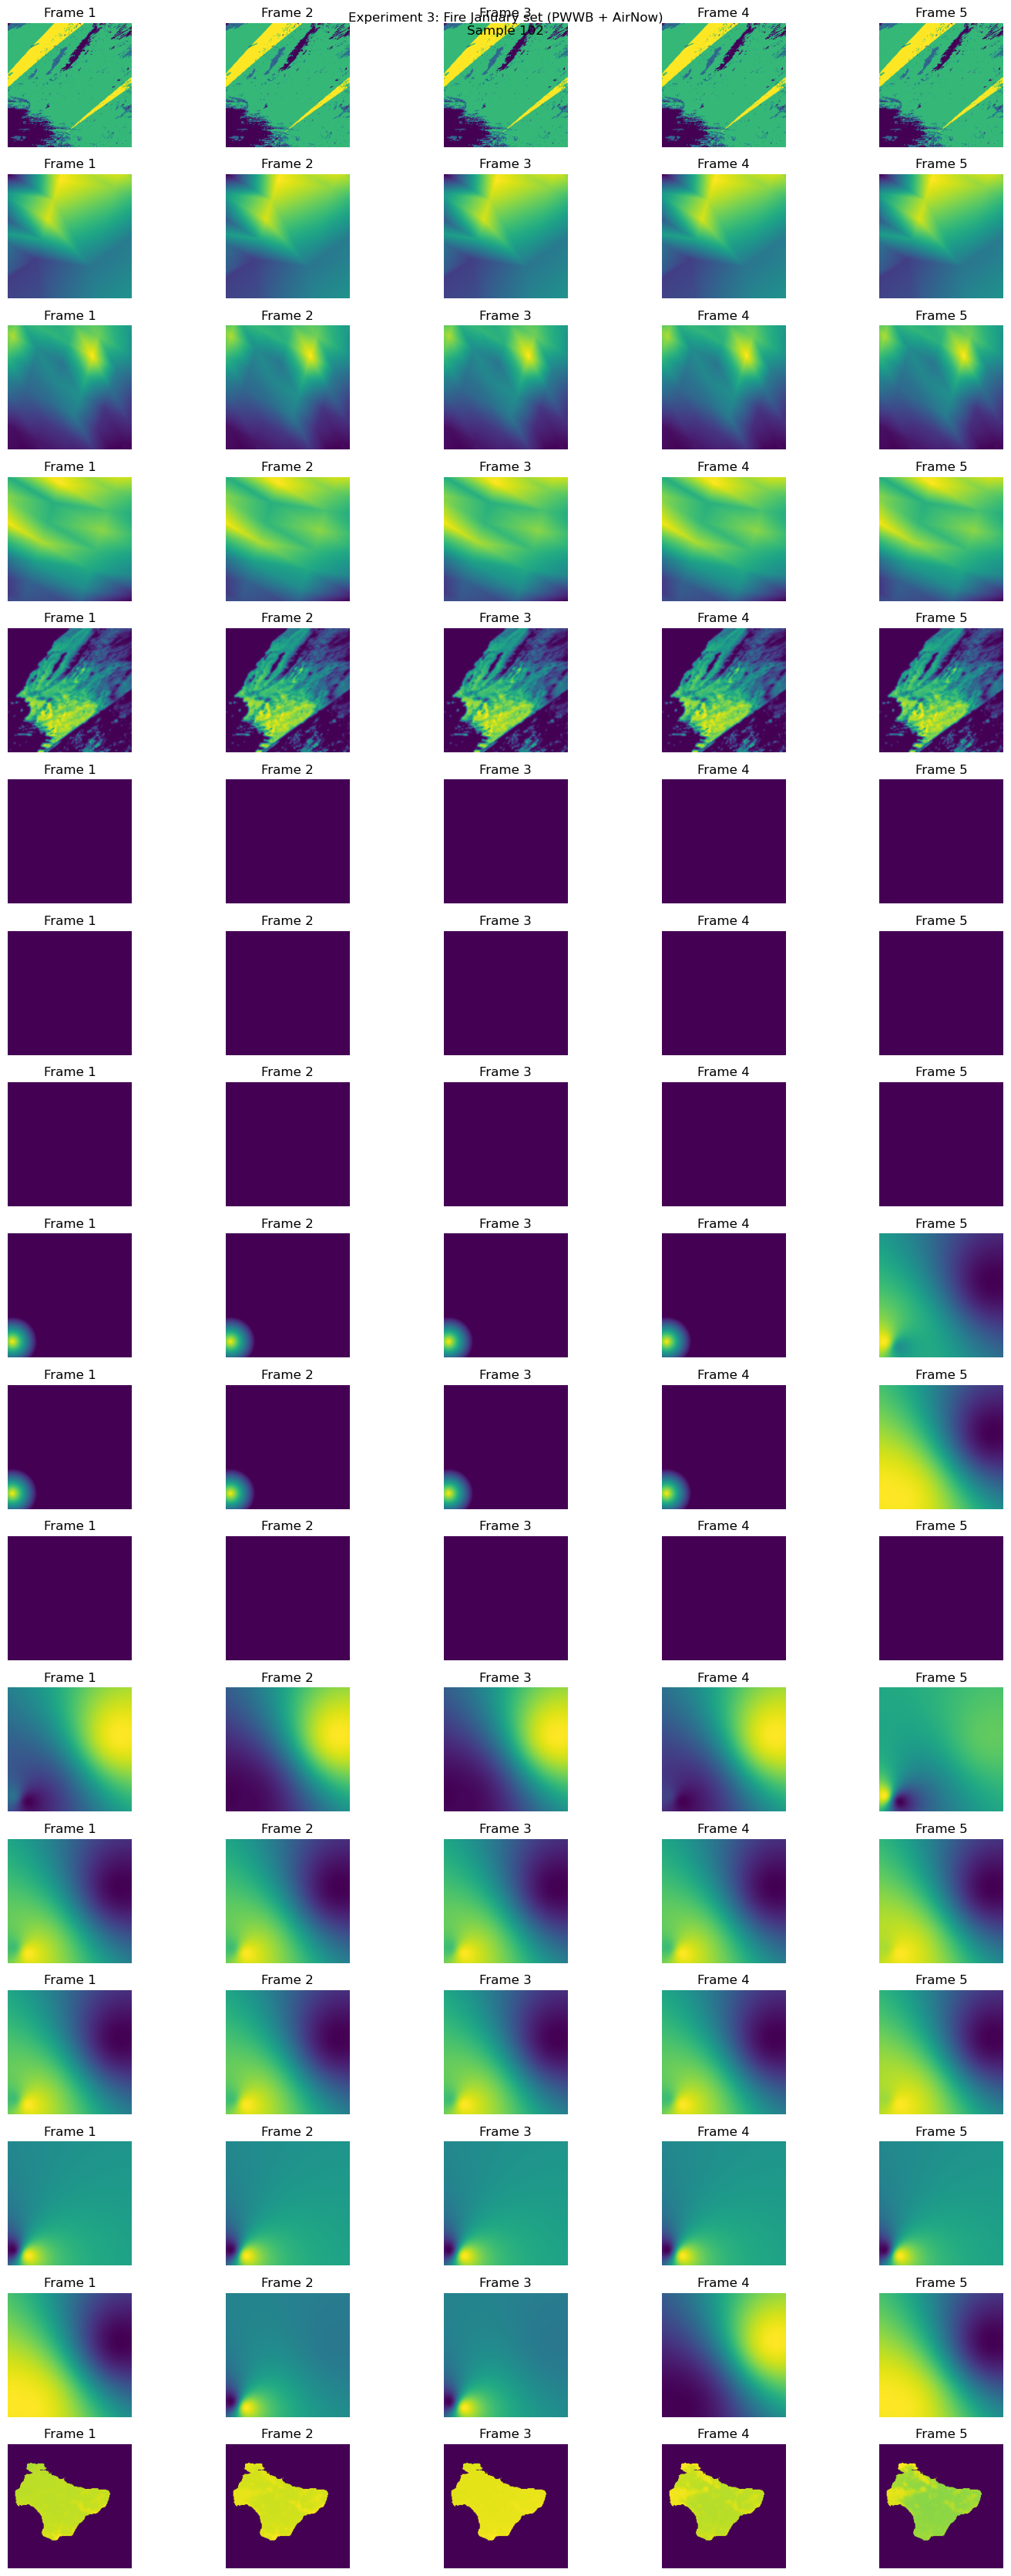

Target values: [22.7 19.1 23.1]


In [7]:
# Function to visualize data from experiment
def visualize_experiment_data(X, y, sample_idx=None):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        for f in range(n_frames):
            ax = axes[c, f]
            ax.imshow(X[sample_idx, f, :, :, c])
            if f == 0:
                ax.set_ylabel(f"Channel {c}")
            ax.set_title(f"Frame {f+1}")
            ax.axis("off")
    
    # Set title
    plt.suptitle(f"Experiment 3: Fire January set (PWWB + AirNow)\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    print(f"Target values: {y[sample_idx]}")

# Visualize a sample from the experiment
print("Visualizing data...")
visualize_experiment_data(X_exp3_train_scaled, Y_jan_train)

# Model

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

2025-05-20 11:06:12.971376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 11:06:13.355961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 11:06:14.847688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



==== Running Experiment 3: Fire January set (PWWB + AirNow) ====
Training data shape: (123, 5, 200, 200, 17)
Target data shape: (123, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │        17,340 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,634 (2.59 MB)

 Trainable params: 678,634 (2.59 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - loss: 14.3385 - val_loss: 8.3013
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - loss: 9.2828 - val_loss: 8.7927
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - loss: 9.9535 - val_loss: 7.9909
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - loss: 10.2690 - val_loss: 7.8645
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - loss: 9.4282 - val_loss: 7.9916
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - loss: 8.8780 - val_loss: 7.7736
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - loss: 8.7362 - val_loss: 7.6795
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - loss: 9.5654 - val_loss: 8.3584
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - loss: 9.2624 - val_loss: 6.9371
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - loss: 6.5938 - val_loss: 6.3584
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - loss: 5.1321 - val_loss: 5.6440
Epoch 12/50
25/25 ━━

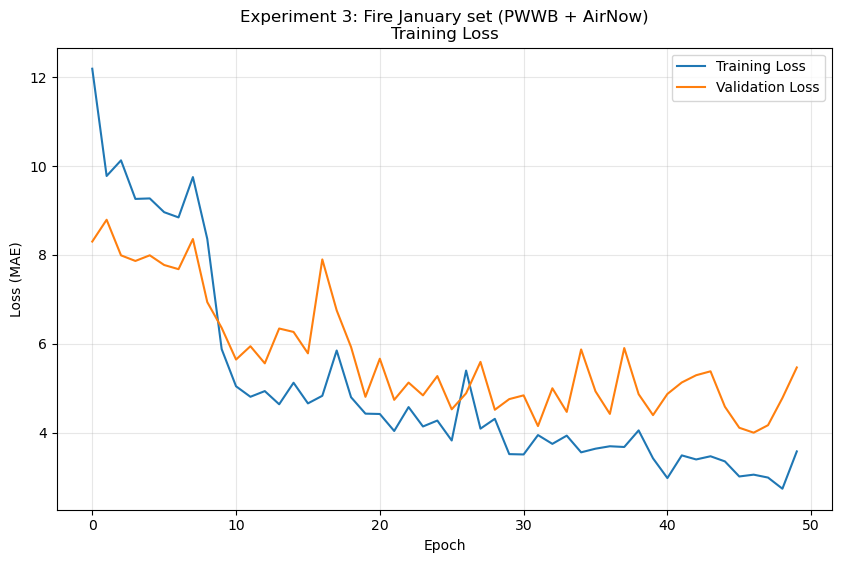

In [9]:
# Run Experiment 3: Fire January set (PWWB + AirNow)
print("\n==== Running Experiment 3: Fire January set (PWWB + AirNow) ====")
print(f"Training data shape: {X_exp3_train_scaled.shape}")
print(f"Target data shape: {Y_jan_train.shape}")

# Build model
seq = Sequential()

seq.add(
    InputLayer(shape=X_exp3_train_scaled.shape[1:])
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())
seq.add(Dense(Y_jan_train.shape[1], activation='relu'))

# Compile model
seq.compile(loss='mean_absolute_error', optimizer='adam')

# Print model summary
seq.summary()

# Train model
print(f"\nTraining model...")
epochs = 50  # Reduced epochs for faster testing
batch_size = 4
history = seq.fit(
    X_exp3_train_scaled, Y_jan_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

# Evaluate model
print(f"\nEvaluating model...")
test_loss = seq.evaluate(X_exp3_test_scaled, Y_jan_test, verbose=0)
print(f"Test MAE: {test_loss:.4f}")

# Make predictions
y_pred = seq.predict(X_exp3_test_scaled, verbose=0)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(Y_jan_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_jan_test, y_pred))
r2 = r2_score(Y_jan_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
plt.title('Experiment 3: Fire January set (PWWB + AirNow)\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results
results_dir = os.path.join(output_dir, "experiment3", "results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
seq.save(os.path.join(results_dir, "model.h5"))

exp3_results = {
    'model': seq,
    'history': history,
    'loss': test_loss,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'y_pred': y_pred,
    'y_test': Y_jan_test
}

# Evaluate

In [10]:
# Analyze results
print(f"\nDetailed analysis for Experiment 3:")
X_test = X_exp3_test_scaled
y_test = Y_jan_test
y_pred = exp3_results['y_pred']
model = exp3_results['model']
description = "Fire January set (PWWB + AirNow), 3rd week"

print(f"Analyzing Experiment 3: {description}")


Detailed analysis for Experiment 3:
Analyzing Experiment 3: Fire January set (PWWB + AirNow), 3rd week



1. Plotting prediction comparison...


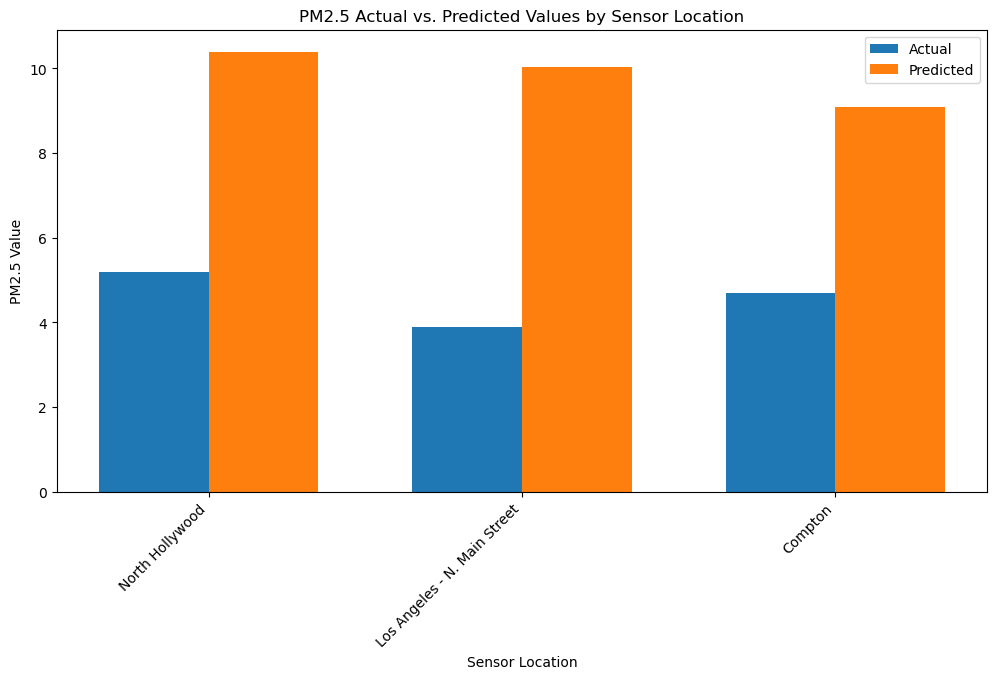


2. Plotting scatter comparison...


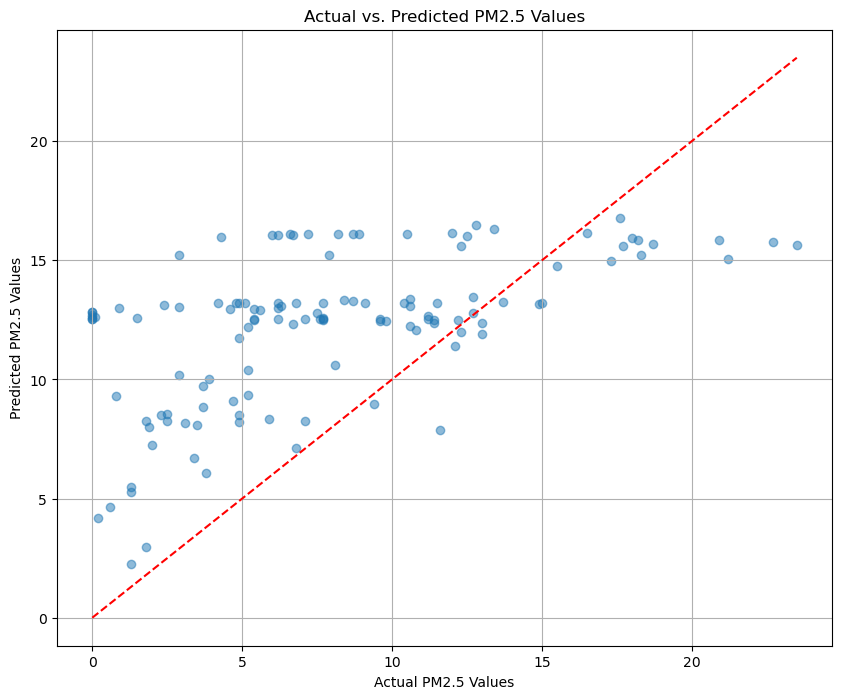


3. Plotting error by sensor...


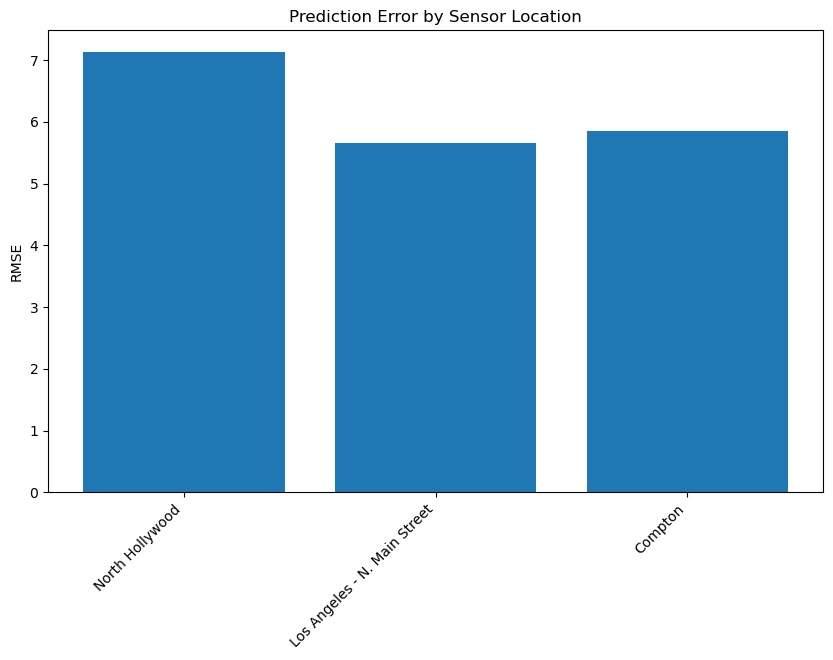


4. Plotting time series comparison...


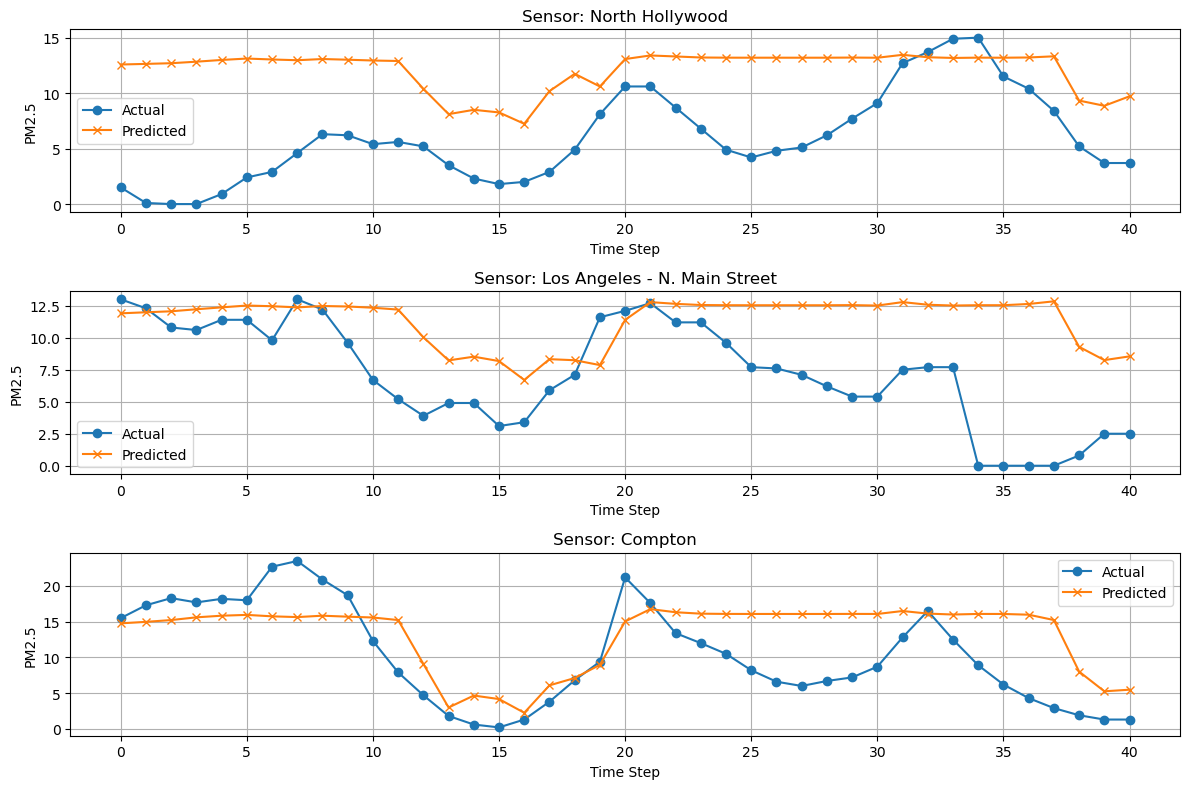


5. Plotting time series with shifted predictions...


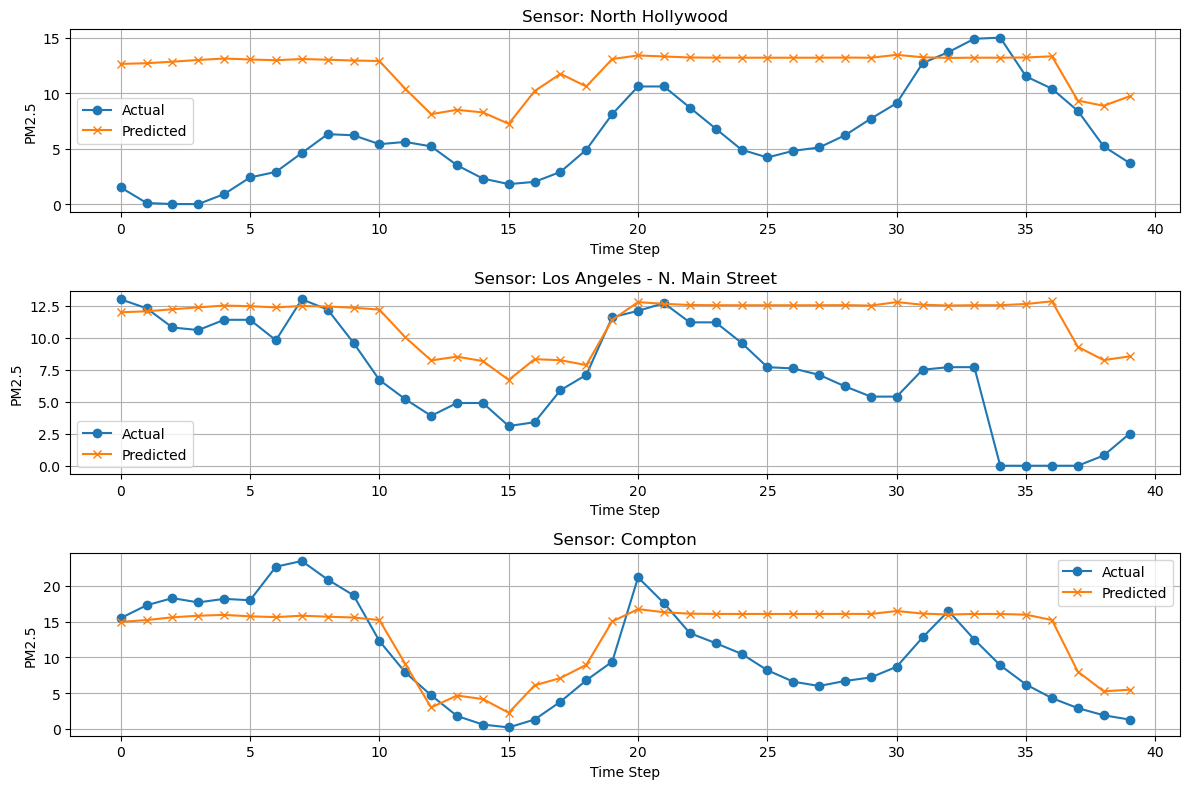


6. Printing metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 6.25
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 79.48%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 6.44
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 64.42%

Frame 2 (Hour 2) All Locations - Raw RMSE: 7.36
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 74.37%

Frame 3 (Hour 3) All Locations - Raw RMSE: 7.58
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 78.11%

Frame 4 (Hour 4) All Locations - Raw RMSE: 7.57
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 80.19%

Frame 5 (Hour 5) All Locations - Raw RMSE: 7.13
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 70.17%

Frame 6 (Hour 6) All Locations - Raw RMSE: 6.33
Frame 6 (Hour 6) All Locations 

In [11]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Sensor names (use AirNow sensor names if available)
if hasattr(jan_airnow, 'sensor_names') and jan_airnow.sensor_names is not None:
    sensor_names = jan_airnow.sensor_names
else:
    sensor_names = ["North Hollywood", "Los Angeles - N. Main Street", "Compton"]

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_test, sensor_names, sample_idx=12)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_test, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, y_test, sensor_names, shift_pred=1)

print("\n6. Printing metrics...")
print_metrics(y_pred, y_test, sensor_names)

In [ ]:
# Save experiment comparison
with open(os.path.join(output_dir, 'experiment3_results.txt'), 'w') as f:
    f.write("==== Experiment 3 Results ====\n")
    f.write(f"Experiment 3 (Fire January set (PWWB + AirNow), 3rd week): MAE = {exp3_results['mae']:.4f}, RMSE = {exp3_results['rmse']:.4f}, R² = {exp3_results['r2']:.4f}\n")
    f.write(f"\nAnalysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nExperiment 3 complete!")


Experiment 3 complete!


: 